In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import os
import tqdm
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
#needed for DNN 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM,GRU,Bidirectional
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
# from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
# from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
# from sklearn.preprocessing import LabelEncoder
# from tensorflow.keras.preprocessing.text import Tokenizer
# from sklearn.utils import shuffle

In [3]:
train = pd.read_csv('data/train_df.csv')
test = pd.read_csv('data/final dataset/test_df.csv')

train = train.drop(['ABSTRACT'], axis=1)
test = test.drop(['ABSTRACT'], axis=1)

In [4]:
ID_COL = 'id'

TARGET_COLS = ['Analysis of PDEs', 'Applications',
               'Artificial Intelligence', 'Astrophysics of Galaxies',
               'Computation and Language', 'Computer Vision and Pattern Recognition',
               'Cosmology and Nongalactic Astrophysics',
               'Data Structures and Algorithms', 'Differential Geometry',
               'Earth and Planetary Astrophysics', 'Fluid Dynamics',
               'Information Theory', 'Instrumentation and Methods for Astrophysics',
               'Machine Learning', 'Materials Science', 'Methodology', 'Number Theory',
               'Optimization and Control', 'Representation Theory', 'Robotics',
               'Social and Information Networks', 'Statistics Theory',
               'Strongly Correlated Electrons', 'Superconductivity',
               'Systems and Control']

TOPIC_COLS = ['Computer Science', 'Mathematics', 'Physics', 'Statistics']

print(f'\n Train contains {train.shape[0]} samples and {train.shape[1]} variables')
print(f'\n Test contains {test.shape[0]} samples and {test.shape[1]} variables')
print(f'\n Number of distinct SUB TOPICS is {len(TARGET_COLS)}')

features = [c for c in train.columns if c not in [ID_COL] + TARGET_COLS]
print(f'\n The dataset contains {len(features)} features')


 Train contains 14004 samples and 31 variables

 Test contains 6002 samples and 6 variables

 Number of distinct SUB TOPICS is 25

 The dataset contains 5 features


In [5]:
100 * (train[TARGET_COLS].sum()/(train.shape[0])).sort_values(ascending=False)

Machine Learning                                27.313625
Artificial Intelligence                          9.825764
Robotics                                         6.812339
Computer Vision and Pattern Recognition          6.705227
Strongly Correlated Electrons                    6.376750
Materials Science                                5.534133
Computation and Language                         4.605827
Cosmology and Nongalactic Astrophysics           4.520137
Optimization and Control                         4.434447
Social and Information Networks                  4.420166
Analysis of PDEs                                 4.334476
Applications                                     4.227364
Astrophysics of Galaxies                         4.098829
Methodology                                      4.098829
Systems and Control                              4.041702
Differential Geometry                            3.963153
Superconductivity                                3.870323
Statistics The

In [6]:
train.shape

(14004, 31)

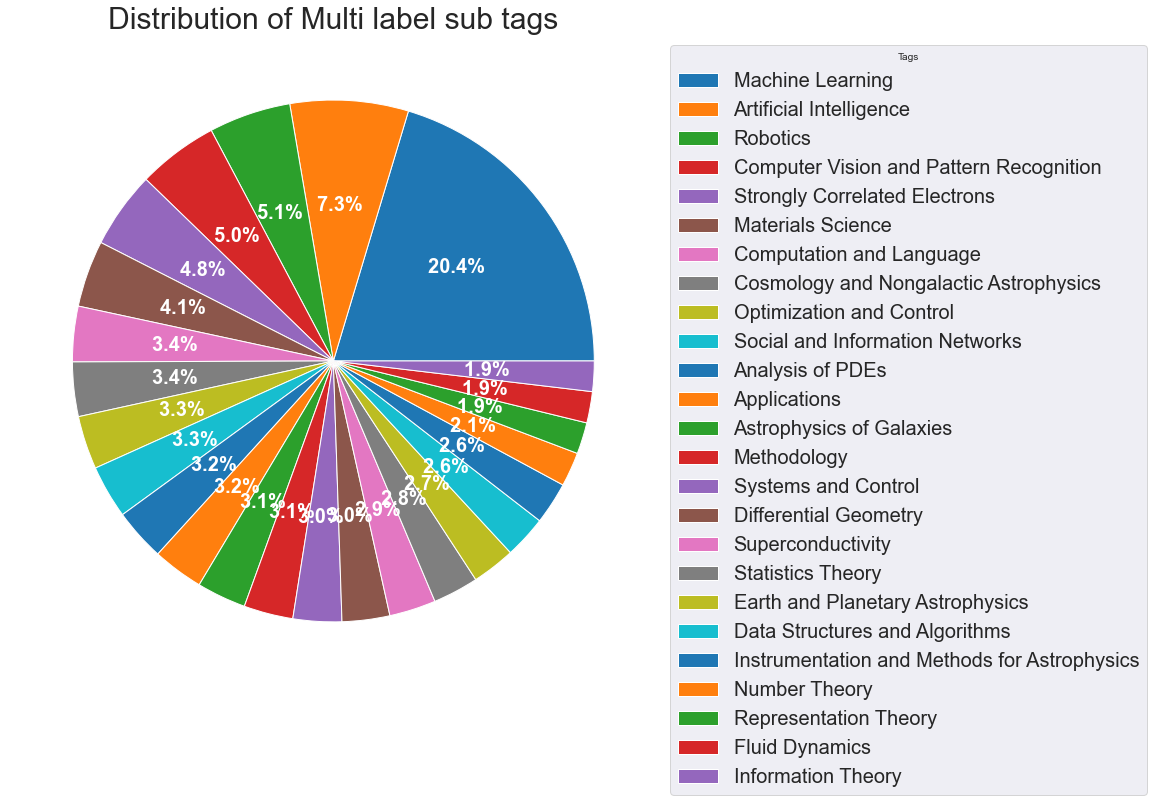

In [7]:
s=100*(train[TARGET_COLS].sum()/(train.shape[0])).sort_values(ascending=False)
ss=s.to_dict()

labels = []
sizes = []

for x, y in ss.items():
    labels.append(x)
    sizes.append(y)
fig, ax = plt.subplots(figsize=(12,12), subplot_kw=dict(aspect="equal"))

tags = [x for x in labels]

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}% ".format(pct)

# def func(pct, allvals):
#     absolute = int(round(pct/100*np.sum(allvals)))
#     return "{:.1f}%\n({:d} Papers)".format(pct, absolute)


wedges, texts, autotexts = ax.pie(sizes, autopct=lambda pct: func(pct, sizes),
                                  textprops=dict(color="w"))

ax.legend(wedges, tags,
          title="Tags",
          loc=2,
          bbox_to_anchor = (1,1), 
          prop={'size': 20})

plt.setp(autotexts, size=20,weight="bold")

ax.set_title("Distribution of Multi label sub tags", fontsize=30)

plt.show()

In [8]:
train.head()

,id,Computer Science,Mathematics,Physics,Statistics,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,Computation and Language,...,Number Theory,Optimization and Control,Representation Theory,Robotics,Social and Information Networks,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control,cleaned_text
0,1824,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,evergrowing datasets inside observational astr...
1,3094,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,propose framework consider optimal tmatchings ...
2,8463,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,nanostructures open shell transition metal mol...
3,2082,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,star selfgravitating fluid inside pressure buo...
4,8687,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,deep neural perception control network likely ...


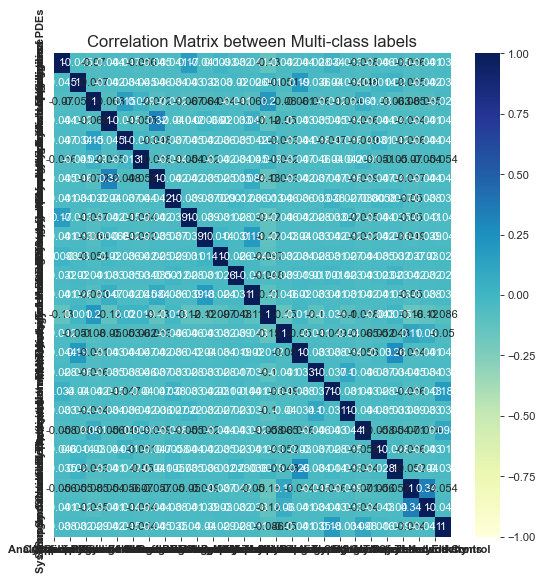

In [9]:
def plotCorrelationMatrix(df, graphWidth):
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = sns.heatmap(corr, vmin=-1, vmax=1,cmap="YlGnBu", annot=True)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=0, weight = 'bold')
    plt.yticks(range(len(corr.columns)), corr.columns, rotation=90, weight = 'bold')
    plt.gca().xaxis.tick_bottom()
    plt.title(f'Correlation Matrix between Multi-class labels', fontsize=15)
    plt.show()

cor_train = train.drop('id', axis =1)
cor_train = cor_train.drop(TOPIC_COLS, axis =1)
plotCorrelationMatrix(cor_train, 8)

In [10]:
# 100 * (test[TOPIC_COLS].sum()/(test.shape[0])).sort_values(ascending=False)

In [11]:
train.head()

,id,Computer Science,Mathematics,Physics,Statistics,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,Computation and Language,...,Number Theory,Optimization and Control,Representation Theory,Robotics,Social and Information Networks,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control,cleaned_text
0,1824,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,evergrowing datasets inside observational astr...
1,3094,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,propose framework consider optimal tmatchings ...
2,8463,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,nanostructures open shell transition metal mol...
3,2082,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,star selfgravitating fluid inside pressure buo...
4,8687,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,deep neural perception control network likely ...


In [12]:
multi_label_train_df = train.drop(TOPIC_COLS, axis =1)
multi_label_train_df = multi_label_train_df.drop(ID_COL, axis =1)
df = multi_label_train_df.sample(frac=1, random_state=42).reset_index(drop=True)
print(df.columns)
df.head()

Index(['Analysis of PDEs', 'Applications', 'Artificial Intelligence',
       'Astrophysics of Galaxies', 'Computation and Language',
       'Computer Vision and Pattern Recognition',
       'Cosmology and Nongalactic Astrophysics',
       'Data Structures and Algorithms', 'Differential Geometry',
       'Earth and Planetary Astrophysics', 'Fluid Dynamics',
       'Information Theory', 'Instrumentation and Methods for Astrophysics',
       'Machine Learning', 'Materials Science', 'Methodology', 'Number Theory',
       'Optimization and Control', 'Representation Theory', 'Robotics',
       'Social and Information Networks', 'Statistics Theory',
       'Strongly Correlated Electrons', 'Superconductivity',
       'Systems and Control', 'cleaned_text'],
      dtype='object')


,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,Computation and Language,Computer Vision and Pattern Recognition,Cosmology and Nongalactic Astrophysics,Data Structures and Algorithms,Differential Geometry,Earth and Planetary Astrophysics,...,Number Theory,Optimization and Control,Representation Theory,Robotics,Social and Information Networks,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control,cleaned_text
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,gravitational wave astronomy set inside motion...
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,present novel tractable generative model exten...
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,deep neural network widely adopt inside recent...
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,rank largescale graph play fundamental role in...
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,multiagent predictive model essential step con...


In [13]:
# set aside 20% of train and test data for evaluation
df.cleaned_text=df.cleaned_text.astype(str)

X = df.cleaned_text
Y = df.iloc[:,0:25]

def dataset_split(inputs, tags):

    X,X_test,y,y_test = train_test_split(inputs,tags,train_size = 0.9,
                                                  test_size = 0.1,random_state =0)
    X_train,X_valid,y_train,y_valid = train_test_split(X,y,train_size = 0.9,
                                                  test_size = 0.1,random_state =0)
    print("\nDataset Distribution:\n")
    print("\tSet Name","\t\tSize")
    print("\t========\t\t======")

    print("\tFull\t\t\t",len(inputs),
        "\n\tTraining\t\t",len(X_train),
        "\n\tTest\t\t\t",len(X_test),
        "\n\tValidation\t\t",len(X_valid))
  
    return X_train,X_valid,X_test,y_train,y_valid,y_test

X_train,X_valid,X_test,y_train,y_valid,y_test = dataset_split(X,Y)


Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 14004 
	Training		 11342 
	Test			 1401 
	Validation		 1261


In [14]:
# Train Data Tokenization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_length = 200
vocab_size = 55839 

tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>",filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',lower=True)
tokenizer.fit_on_texts(X_train.values)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Taining Data padding
train_sequences = tokenizer.texts_to_sequences(X_train.values)
train_padded = pad_sequences(train_sequences,padding='post', maxlen=max_length)

# Validation Data padding
validation_sequences = tokenizer.texts_to_sequences(X_valid.values)
validation_padded = pad_sequences(validation_sequences,padding='post', maxlen=max_length)

# testing data padding
test_sequences = tokenizer.texts_to_sequences(X_test.values)
test_padded = pad_sequences(test_sequences,padding='post',maxlen=max_length)

Found 55838 unique tokens.


In [15]:
####
embedding_vector = {}
f = open('glove/glove.6B.300d.txt',encoding="utf8")
for line in tqdm.tqdm(f):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embedding_vector[word] = coef
embedding_matrix = np.zeros((vocab_size,300))
for word,i in tqdm.tqdm(word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

400000it [00:16, 24752.79it/s]
100%|████████████████████████████████████████████████████████████████████████| 55838/55838 [00:00<00:00, 457510.68it/s]


In [16]:
def padded_infos(original,encoded,padded):
  print("\n\t\t\t Encoded Sequences ","\n")  
  print(original,"\n",encoded) 
  print("\n\t\t\t Paded Sequences \n",original,"\n",padded)

padded_infos(X_train[2],train_sequences[2],train_padded[2])


			 Encoded Sequences  

deep neural network widely adopt inside recent year exhibit impressive performance inside several application domain however show fooled adversarial example ie image alter barelyperceivable adversarial noise carefully craft mislead classification inside work aim evaluate extent robotvision system embody deeplearning algorithms vulnerable adversarial example propose computationally efficient countermeasure mitigate threat base reject classification anomalous input provide clear understanding safety property deep network intuitive empirical analysis show mapping learn network essentially violate smoothness assumption learn algorithm finally discuss main limitation work include creation realworld adversarial example sketch promise research direction 
 [14355, 66, 112, 1198, 661, 4, 174, 3, 2566, 2991, 76, 107, 475, 549, 528, 669, 8, 2, 1911, 4255, 529, 29, 1198, 4, 3, 2991, 263, 670, 1008, 78, 313, 2, 388, 157, 2719, 1107, 510, 546, 11, 100, 14355, 66, 722, 526, 

In [17]:
# #confusion matrix
# def conf_matrix(y_pred):
#   # preds = np.where(y_pred < 0.5, 0, 1)
#   cm = confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1)) 
# # Transform to df for easier plotting
  
#   cm_df = pd.DataFrame(cm,
#                        index = ['Computer Science', 'Mathematics', 'Physics', 'Statistics'], 
#                        columns = ['Computer Science', 'Mathematics', 'Physics', 'Statistics'])
#   sns.set(font_scale=2) 
#   plt.figure(figsize=(12,8))
#   sns.heatmap(cm_df, annot=True,cmap="OrRd", fmt='g')
#   plt.ylabel('True label',fontsize=20)
#   plt.xlabel('Predicted label',fontsize=20)
#   plt.xticks( rotation=90, weight = 'bold')
#   plt.yticks( rotation=0, weight = 'bold')
#   plt.show()
#   plt.close()

In [18]:
accuracy_threshold = 0.999
from tensorflow import keras
keras.backend.clear_session()
#callback function for early stopping
class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
#     if(logs.get('binary_accuracy') > ACCURACY_THRESHOLD):
      if(logs.get('binary_accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()


In [19]:
embedding_dim=300
num_category = 25
opt=RMSprop(0.001)


In [20]:
def Bidirectional_classifier_model(model_name,file_name,GRU_unit, epochs, batch, p_optimizer:str = 'adam' , 
                                   p_loss:str = 'binary_crossentropy', p_metrics:list = ['binary_accuracy']):
    """
    Build a Bidirectional Models for classification
    """
    filepath = 'models/'+file_name
    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                    factor=0.5, patience=2, 
                                    verbose=1, mode='auto', 
                                    min_delta=0.001, cooldown=1, min_lr=0.00001)
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_binary_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='auto')
    
    callback_list = [acc_callback, checkpoint,reduceLROnPlat ]
    
    print('----------------------------- sequential_classifier_model -----------------------------')
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1],weights=[embedding_matrix],trainable =False),
        tf.keras.layers.SpatialDropout1D(0.2),
        tf.keras.layers.Bidirectional(model_name(GRU_unit,return_sequences=True)),
        tf.keras.layers.Dense(28, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_category, activation='sigmoid')
])
    model.compile(optimizer=p_optimizer, loss = p_loss, metrics = p_metrics)
    model.summary()
    model_history = model.fit(train_padded, y_train, 
                    epochs=epochs,
                    batch_size = batch,
                    validation_data=(validation_padded, y_valid), 
                    verbose=1,
                    callbacks = callback_list)
    return model,model_history

In [21]:
# Bidirection GRU 
BiGRU_model, BiGRU_history = Bidirectional_classifier_model(model_name = GRU,
                                                            file_name = 'mul_label_glove_BiGRU.h5',
                                                            GRU_unit = 128,
                                                            epochs = 20,
                                                            batch = 128)

----------------------------- sequential_classifier_model -----------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 300)          16751700  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 300)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 256)          330240    
_________________________________________________________________
dense (Dense)                (None, 200, 28)           7196      
_________________________________________________________________
dropout (Dropout)            (None, 200, 28)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 200, 128)          3712      
__________________________________

In [22]:
#make predictions

model = load_model("models/mul_label_glove_BiGRU.h5")
predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)
testing_label_seq_numpy = y_test.to_numpy()
evaluation = model.evaluate(test_padded,y_test)
weighted_averaged_recall = average_precision_score(testing_label_seq_numpy, predictions, average='samples')
weighted_averaged_precision = average_precision_score(testing_label_seq_numpy, predictions,  average='weighted')
print('loss {}'.format(evaluation[0]))
print('Accuracy {}'.format(evaluation[1]))
print('Precision {}'.format(weighted_averaged_precision))
print('Recall {}'.format(weighted_averaged_recall))
print('f1 score {}'.format(2*((weighted_averaged_recall*weighted_averaged_precision)/(weighted_averaged_recall+weighted_averaged_precision))))

# conf_matrix(predictions)

44/44 [==============================] - 1s 10ms/step - loss: 0.1169 - binary_accuracy: 0.9543
loss 0.11693675071001053
Accuracy 0.9543468356132507
Precision 0.7258276220560138
Recall 0.8246025470267497
f1 score 0.7720687042665622


In [23]:
#Report generation

def report_generate(pred,classifier):
  # Computer Science	Mathematics	Physics	Statistics

  report = pd.DataFrame(classification_report(y_true = y_test.values.argmax(axis=1), y_pred =np.argmax(pred, axis=1), output_dict=True)).transpose()
  report = report.rename(index={'0': 'Computer Science','1':'Mathematics','2':'Physics', '3': 'Statistics'})
  report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
  report=report.drop(["support"],axis=1)

  columns = ['precision','recall','f1-score']
  report.columns = columns
  plt = report.plot(kind='bar',figsize=(12,6))
  plt.set_title('Multi-class Classification Report for '+str(classifier)+' .', fontsize=20)
  plt.tick_params(axis='x',rotation=30,labelsize=25)
  plt.tick_params(axis='y',rotation=0,labelsize=25)
  plt.legend(['precision', 'recall', 'f1-score'], loc=2,bbox_to_anchor = (1,1), prop={'size': 20})
  plt.grid('white')
  return plt,report

,precision,recall,f1-score
Computer Science,64.71,62.26,63.46
Mathematics,66.67,10.17,17.65
Physics,40.00,1.42,2.74
Statistics,75.44,82.69,78.90
4,50.00,68.89,57.94
5,60.47,60.47,60.47
6,70.27,60.47,65.00
7,67.31,63.64,65.42
8,61.22,75.00,67.42
9,82.35,82.35,82.35


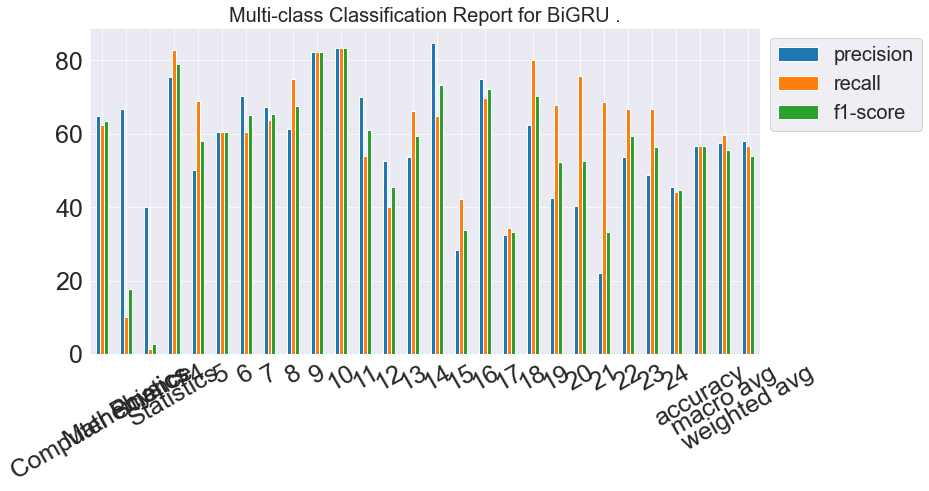

In [24]:
GRUreport=report_generate(predictions,"BiGRU")
GRUreport[1]

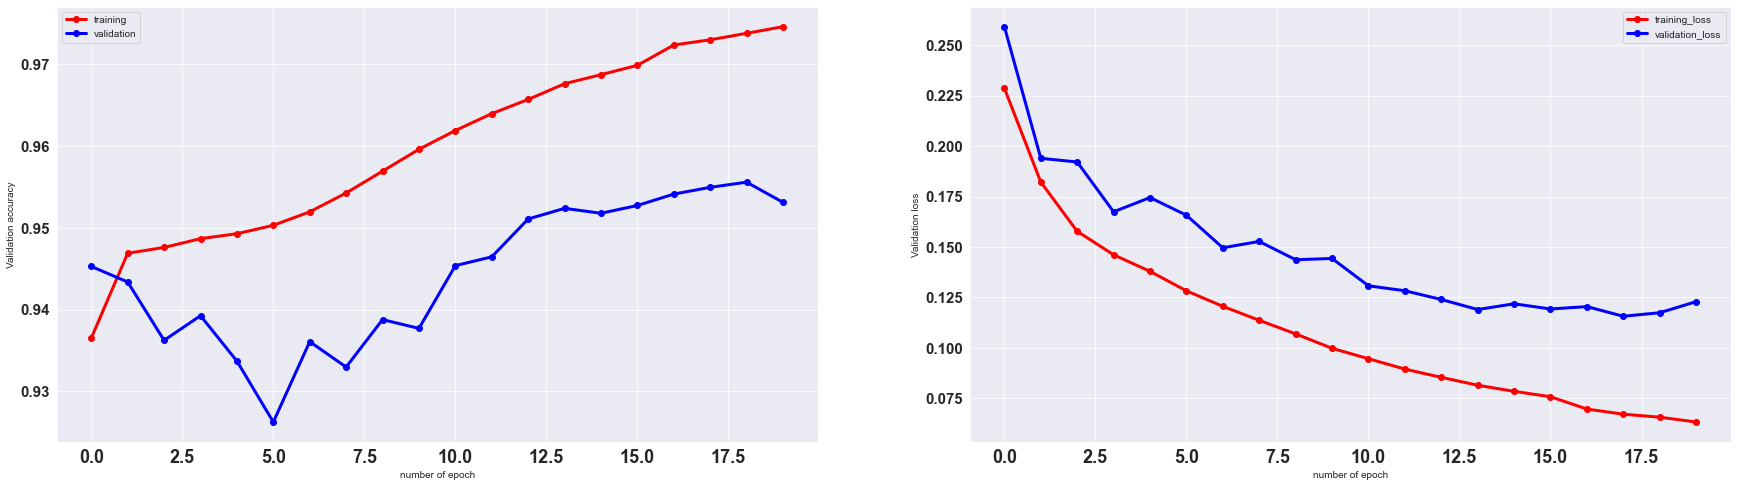

In [25]:
def model_evaluate(history):
  H = history.history
  fig = plt.figure(figsize = (30, 8))
  plt.subplot(121)
  plt.xlabel("number of epoch")
  plt.ylabel("Validation accuracy")
  plt.plot(H['binary_accuracy'], label = 'training', marker='o', color='red', linewidth=3 )
  plt.plot(H['val_binary_accuracy'], label = 'validation', marker='o', color='blue', linewidth=3 )
  plt.xticks( rotation=0, weight = 'bold', )
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=15)
  plt.tick_params(rotation=0,axis='x', labelsize=18)
  plt.grid('white')
  plt.legend()

  plt.subplot(122)
  plt.xlabel("number of epoch")
  plt.ylabel("Validation loss")
  plt.plot(H['loss'], label = 'training_loss', marker='o', color='red', linewidth=3 )
  plt.plot(H['val_loss'], label = 'validation_loss', marker='o', color='blue', linewidth=3 )
  plt.xticks( rotation=0, weight = 'bold', )
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=15)
  plt.tick_params(rotation=0,axis='x', labelsize=18)
  plt.grid('white')
  plt.legend()
    
model_evaluate(BiGRU_history)

In [26]:
BiLSTM_model, BiLSTM_history = Bidirectional_classifier_model(model_name = LSTM,
                                                            file_name = 'mul_label_glove_BiLSTM.h5',
                                                            GRU_unit = 128,
                                                            epochs = 20,
                                                            batch = 128)

----------------------------- sequential_classifier_model -----------------------------
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 300)          16751700  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 256)          439296    
_________________________________________________________________
dense_5 (Dense)              (None, 200, 28)           7196      
_________________________________________________________________
dropout_4 (Dropout)          (None, 200, 28)           0         
_________________________________________________________________
dense_6 (Dense)              (None, 200, 128)          3712      
________________________________

In [27]:
#make predictions


model = load_model("models/mul_label_glove_BiLSTM.h5")
predictions = model.predict(test_padded)
testing_label_seq_numpy = y_test.to_numpy()
evaluation = model.evaluate(test_padded,y_test)
weighted_averaged_recall = average_precision_score(testing_label_seq_numpy, predictions, average='samples')
weighted_averaged_precision = average_precision_score(testing_label_seq_numpy, predictions,  average='weighted')
print('loss {}'.format(evaluation[0]))
print('Accuracy {}'.format(evaluation[1]))
print('Precision {}'.format(weighted_averaged_precision))
print('Recall {}'.format(weighted_averaged_recall))
print('f1 score {}'.format(2*((weighted_averaged_recall*weighted_averaged_precision)/(weighted_averaged_recall+weighted_averaged_precision))))

# conf_matrix(predictions)

44/44 [==============================] - 1s 9ms/step - loss: 0.1188 - binary_accuracy: 0.9548
loss 0.11875161528587341
Accuracy 0.9547749757766724
Precision 0.6842032738675486
Recall 0.8029099604026018
f1 score 0.7388188214166991


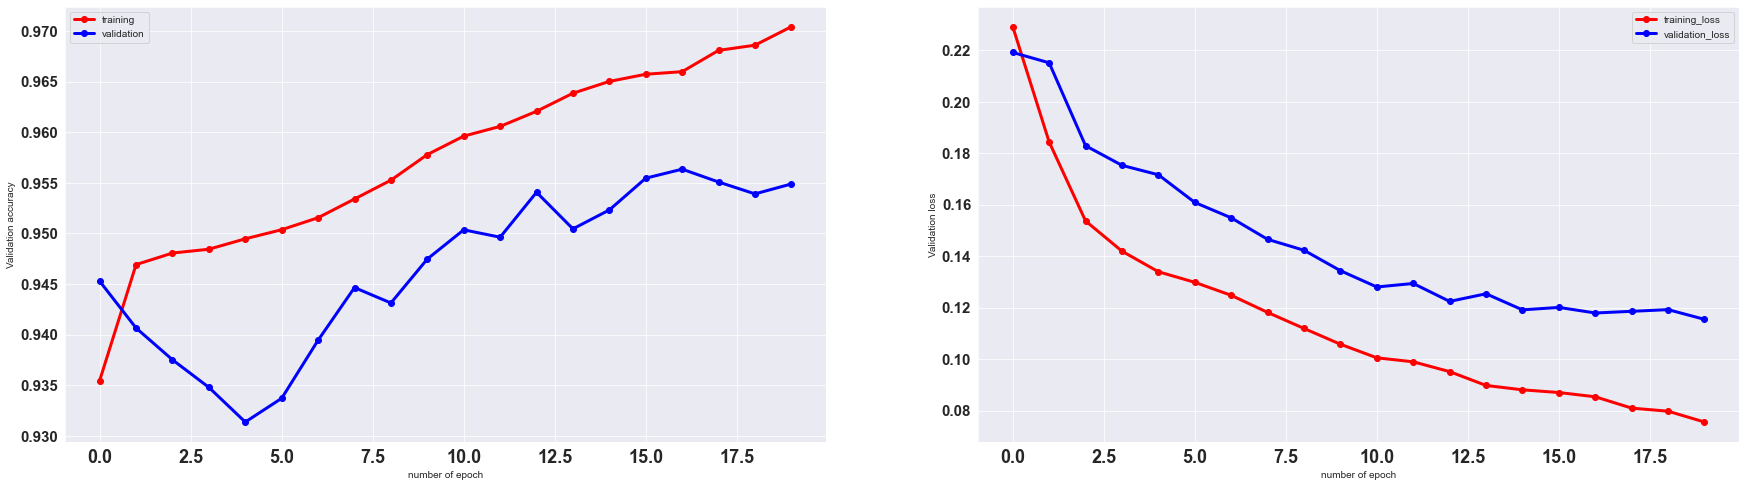

In [28]:
model_evaluate(BiLSTM_history)

In [29]:
def directional_classifier_model(model_name,file_name,GRU_unit, epochs, batch, p_optimizer:str = 'adam' , 
                                   p_loss:str = 'binary_crossentropy', p_metrics:list = ['binary_accuracy']):
    """
    Build a directional Models for classification
    """
    filepath = 'models/'+file_name
    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                    factor=0.5, patience=2, 
                                    verbose=1, mode='auto', 
                                    min_delta=0.001, cooldown=1, min_lr=0.00001)
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_binary_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='auto')
    
    callback_list = [acc_callback, checkpoint]
    
    print('----------------------------- sequential_classifier_model -----------------------------')
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1],weights=[embedding_matrix],trainable =False),
        tf.keras.layers.SpatialDropout1D(0.2),
        model_name(GRU_unit,return_sequences=True),
#         model_name(128, dropout = 0.2),
        tf.keras.layers.Dense(28, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_category, activation='sigmoid')
])
    model.compile(optimizer=p_optimizer, loss = p_loss, metrics = p_metrics)
    model.summary()
    model_history = model.fit(train_padded, y_train, 
                    epochs=epochs,
                    batch_size = batch,
                    validation_data=(validation_padded, y_valid), 
                    verbose=1,
                    callbacks = callback_list)
    return model,model_history

----------------------------- sequential_classifier_model -----------------------------
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 300)          16751700  
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 200, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 200, 128)          219648    
_________________________________________________________________
dense_10 (Dense)             (None, 200, 28)           3612      
_________________________________________________________________
dropout_8 (Dropout)          (None, 200, 28)           0         
_________________________________________________________________
dense_11 (Dense)             (None, 200, 128)          3712      
________________________________

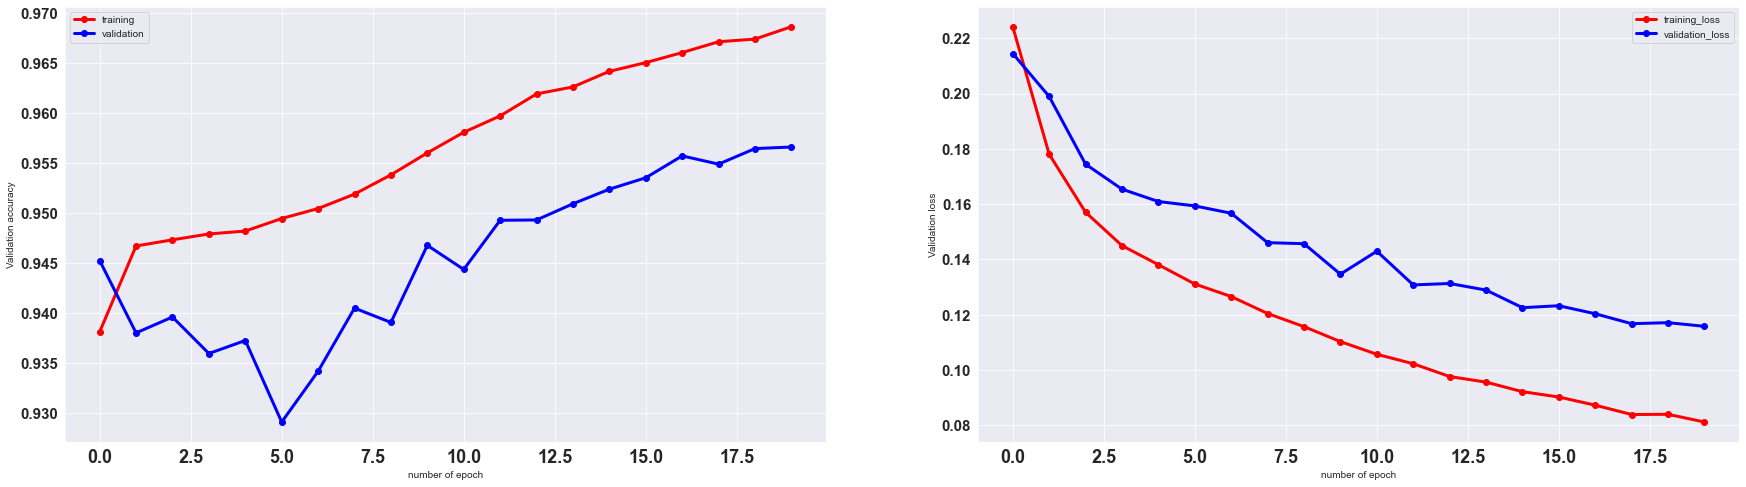

In [30]:
LSTM_model, LSTM_history =directional_classifier_model(model_name = LSTM,
                                                            file_name = 'mul_label_glove_LSTM.h5',
                                                            GRU_unit = 128,
                                                            epochs = 20,
                                                            batch = 128)
model_evaluate(LSTM_history)

In [31]:
#make predictions


model = load_model("models/mul_label_glove_LSTM.h5")
predictions = model.predict(test_padded)
testing_label_seq_numpy = y_test.to_numpy()
evaluation = model.evaluate(test_padded,y_test)
weighted_averaged_recall = average_precision_score(testing_label_seq_numpy, predictions, average='samples')
weighted_averaged_precision = average_precision_score(testing_label_seq_numpy, predictions,  average='micro')
print('loss {}'.format(evaluation[0]))
print('Accuracy {}'.format(evaluation[1]))
print('Precision {}'.format(weighted_averaged_precision))
print('Recall {}'.format(weighted_averaged_recall))
print('f1 score {}'.format(2*((weighted_averaged_recall*weighted_averaged_precision)/(weighted_averaged_recall+weighted_averaged_precision))))

# conf_matrix(predictions)

44/44 [==============================] - 0s 6ms/step - loss: 0.1128 - binary_accuracy: 0.9583
loss 0.11277355998754501
Accuracy 0.9582583904266357
Precision 0.6987649078491593
Recall 0.8038703922648165
f1 score 0.7476417205571911


----------------------------- sequential_classifier_model -----------------------------
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 300)          16751700  
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 200, 300)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 200, 128)          165120    
_________________________________________________________________
dense_15 (Dense)             (None, 200, 28)           3612      
_________________________________________________________________
dropout_12 (Dropout)         (None, 200, 28)           0         
_________________________________________________________________
dense_16 (Dense)             (None, 200, 128)          3712      
________________________________

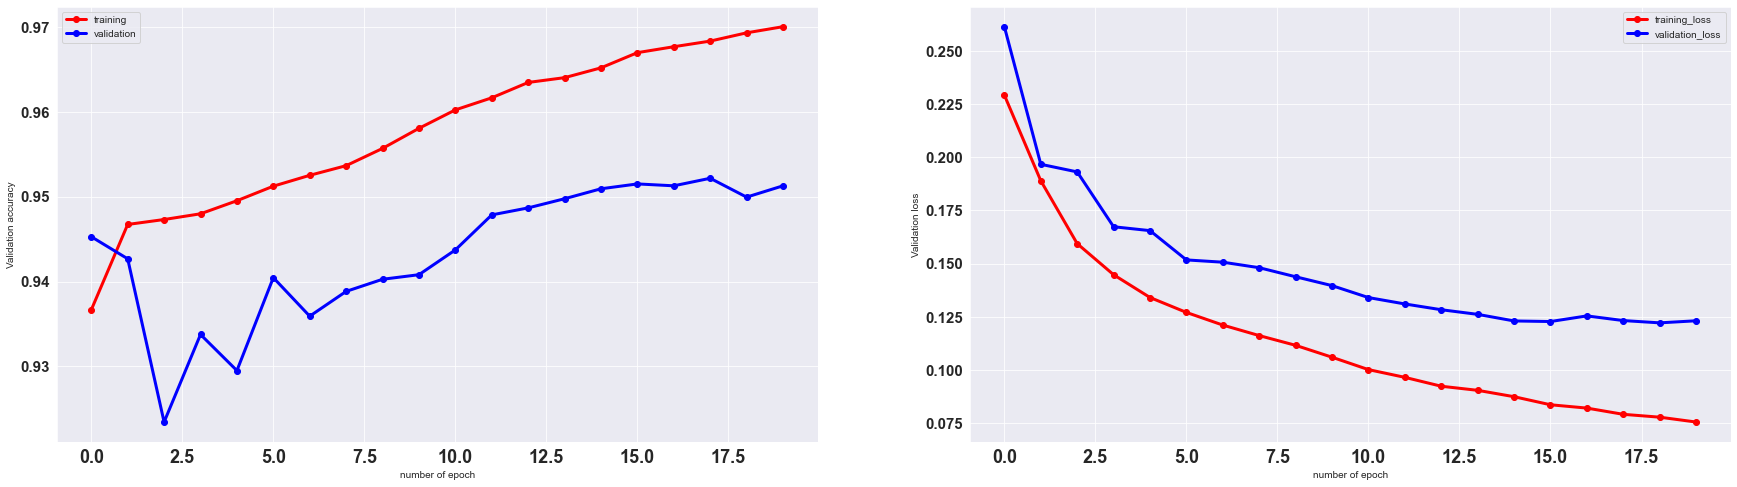

In [32]:
GRU_model, GRU_history =directional_classifier_model(model_name = GRU,
                                                            file_name = 'glove_GRU.h5',
                                                            GRU_unit = 128,
                                                            epochs = 20,
                                                            batch = 128)
model_evaluate(GRU_history)

In [34]:
#make predictions


model = load_model("models/glove_GRU.h5")
predictions = model.predict(test_padded)
testing_label_seq_numpy = y_test.to_numpy()
evaluation = model.evaluate(test_padded,y_test)
weighted_averaged_recall = average_precision_score(testing_label_seq_numpy, predictions, average='samples')
weighted_averaged_precision = average_precision_score(testing_label_seq_numpy, predictions,  average='micro')
print('loss {}'.format(evaluation[0]))
print('Accuracy {}'.format(evaluation[1]))
print('Precision {}'.format(weighted_averaged_precision))
print('Recall {}'.format(weighted_averaged_recall))
print('f1 score {}'.format(2*((weighted_averaged_recall*weighted_averaged_precision)/(weighted_averaged_recall+weighted_averaged_precision))))

# conf_matrix(predictions)

44/44 [==============================] - 0s 5ms/step - loss: 0.1229 - binary_accuracy: 0.9516
loss 0.12293834984302521
Accuracy 0.951606035232544
Precision 0.6849499194202292
Recall 0.8045162872317788
f1 score 0.7399340295881105


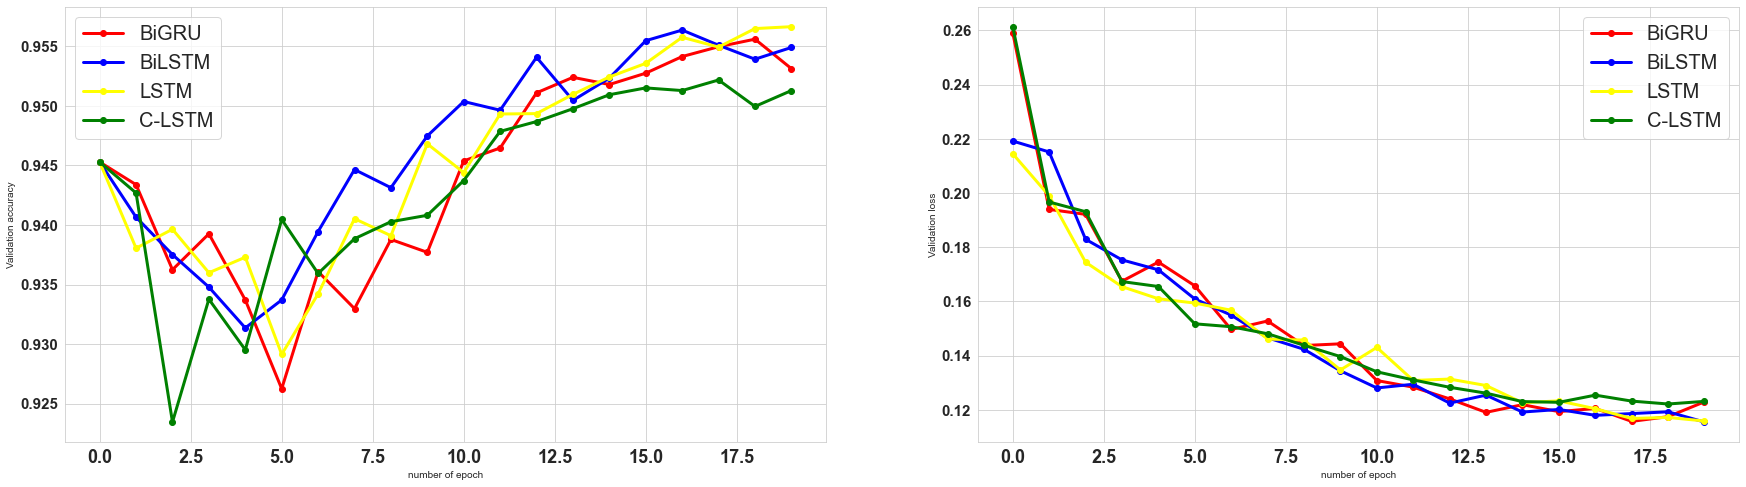

In [35]:
# Plot all model results
def model_all_evaluate(history1,history2,history3,history4):
  sns.set_style("whitegrid")
  H1 = history1.history
  H2 = history2.history
  H3 = history3.history
  H4 = history4.history
  fig = plt.figure(figsize = (30, 8))
  plt.subplot(121)
  plt.xlabel("number of epoch")
  plt.ylabel("Validation accuracy")
  plt.plot(H1['val_binary_accuracy'], label = 'BiGRU', marker='o', color='red', linewidth=3)
  plt.plot(H2['val_binary_accuracy'], label = 'BiLSTM', marker='o', color='blue', linewidth=3)
  plt.plot(H3['val_binary_accuracy'], label = 'LSTM', marker='o', color='yellow', linewidth=3)
  plt.plot(H4['val_binary_accuracy'], label = 'C-LSTM', marker='o', color='green', linewidth=3)
  plt.xticks( rotation=0, weight = 'bold')
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=15)
  plt.tick_params(rotation=0,axis='x', labelsize=18)
  plt.grid('white')
  plt.legend(prop={'size': 20})

  plt.subplot(122)
  plt.xlabel("number of epoch")
  plt.ylabel("Validation loss")
  plt.plot(H1['val_loss'], label = 'BiGRU', marker='o', color='red', linewidth=3)
  plt.plot(H2['val_loss'], label = 'BiLSTM', marker='o', color='blue', linewidth=3)
  plt.plot(H3['val_loss'], label = 'LSTM', marker='o', color='yellow', linewidth=3)
  plt.plot(H4['val_loss'], label = 'C-LSTM', marker='o', color='green', linewidth=3)
  plt.xticks( rotation=0, weight = 'bold')
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=15)
  plt.tick_params(rotation=0,axis='x', labelsize=18)
  plt.grid('white')
  plt.legend(prop={'size': 20})
model_all_evaluate(BiGRU_history, BiLSTM_history,LSTM_history, GRU_history )

In [36]:
Bigru = load_model("models/mul_label_glove_BiGRU.h5")
Bilstm = load_model("models/mul_label_glove_BiLSTM.h5")
lstm = load_model("models/mul_label_glove_LSTM.h5")
gru = load_model("models/glove_GRU.h5")
MLA = {
     'Bidirectional GRU' : Bigru,
     'Bidirectional LSTM' : Bilstm,
     'LSTM' : lstm,
     'GRU' : gru, 
}

columns = []
compare = pd.DataFrame(columns = columns)
# n_classes=4
row_index = 0
for name,alg in MLA.items():
    MLA_name = name
    evaluation = alg.evaluate(test_padded,y_test)
    y_pred = alg.predict(test_padded)
    weighted_averaged_recall = average_precision_score(testing_label_seq_numpy, y_pred, average='samples')
    weighted_averaged_precision = average_precision_score(testing_label_seq_numpy, y_pred,  average='micro')

    weighted_averaged_f1 = 2*((weighted_averaged_recall*weighted_averaged_precision)/(weighted_averaged_recall+weighted_averaged_precision))
    compare.loc[row_index,'Name'] = MLA_name
    compare.loc[row_index, 'Accuracy'] = evaluation[1]
    compare.loc[row_index, 'loss'] = evaluation[0]
    compare.loc[row_index, 'Precision'] = weighted_averaged_precision
    compare.loc[row_index, 'Recall'] = weighted_averaged_recall
    compare.loc[row_index, 'F1 Score'] = weighted_averaged_f1
   

    row_index+=1
    
compare.sort_values(by = ['Accuracy'], ascending = False, inplace = True)    
compare

44/44 [==============================] - 0s 5ms/step - loss: 0.1229 - binary_accuracy: 0.9516


,Name,Accuracy,loss,Precision,Recall,F1 Score
2,LSTM,0.958258,0.112774,0.698765,0.803870,0.747642
1,Bidirectional LSTM,0.954775,0.118752,0.695563,0.802910,0.745391
0,Bidirectional GRU,0.954347,0.116937,0.719976,0.824603,0.768746
3,GRU,0.951606,0.122938,0.684950,0.804516,0.739934
